# 花卉图像分类实验

## 实验介绍

本实验主要介绍如何使用MindSpore进行花卉图像分类实验。定义卷积神经网络，并利于该网络进行花卉分类训练和测试。

## 实验目的

- 掌握如何使用MindSpore进行卷积神经网络的开发。
- 了解如何使用MindSpore进行花卉图片分类任务的训练。
- 了解如何使用MindSpore进行花卉图片分类任务的测试。

## 预备知识

- 熟练使用Python。
- 具备一定的深度学习理论知识，如卷积神经网络、损失函数、优化器，训练策略等。
- 了解华为云的基本使用方法，包括[训练作业](https://support.huaweicloud.com/engineers-modelarts/modelarts_23_0046.html)等功能。华为云官网：https://www.huaweicloud.com
- 了解并熟悉MindSpore AI计算框架，MindSpore官网：https://www.mindspore.cn/

## 实验环境

- MindSpore 1.2（MindSpore版本会定期更新，本指导也会定期刷新，与版本配套）；
- 华为云ModelArts：ModelArts是华为云提供的面向开发者的一站式AI开发平台，集成了昇腾AI处理器资源池，用户可以在该平台下体验MindSpore。

### 数据集准备

flower_photos共五种鲜花的图片数据，分别为雏菊（daisy ）、蒲公英（dandelion）、玫瑰花（roses）、向日葵(sunflowers)、郁金香（tulips），其中每种约800张图像数据，共计约3670张，可用于深度学习图像分类练习使用，可以在[这里](https://hciaai.obs.cn-north-4.myhuaweicloud.com:443/flower_photos.zip)下载数据集，并解压到本地。

```
daisy           633张     
dandelion       898张
roses           641张
sunflowers      699张  
tulips          799张
```

## 实验步骤

### 导入MindSpore模块和辅助模块

用到的框架主要包括：MindSpore，主要用于深度学习算法的构建，这里主要用于卷积神经网络的搭建，主要以开源的花类数据集为基础，基MindSpore深度学习框架和卷积神经网络（CNN）对花的类型进行分类识别。

In [1]:
#easydict模块用于以属性的方式访问字典的值
from easydict import EasyDict as edict
#glob模块主要用于查找符合特定规则的文件路径名，类似使用windows下的文件搜索
import glob
#os模块主要用于处理文件和目录
import os

import numpy as np
import matplotlib.pyplot as plt

import mindspore
#导入mindspore框架数据集
import mindspore.dataset as ds
#vision.c_transforms模块是处理图像增强的高性能模块，用于数据增强图像数据改进训练模型。
import mindspore.dataset.vision.c_transforms as CV
#c_transforms模块提供常用操作，包括OneHotOp和TypeCast
import mindspore.dataset.transforms.c_transforms as C
from mindspore.common import dtype as mstype
from mindspore import context
#导入模块用于初始化截断正态分布
from mindspore.common.initializer import TruncatedNormal
from mindspore import nn
from mindspore.train import Model
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor, TimeMonitor
from mindspore.train.serialization import load_checkpoint, load_param_into_net
from mindspore import Tensor
# 设置MindSpore的执行模式和设备
context.set_context(mode=context.GRAPH_MODE, device_target="GPU")


### 变量定义

In [2]:
cfg = edict({
    'data_path': 'flower_photos',
    'data_size': 3670,
    'image_width': 100,  # 图片宽度
    'image_height': 100,  # 图片高度
    'batch_size': 32,
    'channel': 3,  # 图片通道数
    'num_class':5,  # 分类类别
    'weight_decay': 0.01,
    'lr': 0.001,  # 学习率
    'dropout_ratio': 0.5,
    'epoch_size': 600,  # 训练次数
    'sigma': 0.01,
    'save_checkpoint_steps': 1,  # 多少步保存一次模型
    'keep_checkpoint_max': 3,  # 最多保存多少个模型
    'output_directory': './model',  # 保存模型路径
    'output_prefix': "checkpoint_classification"  # 保存模型文件名字
})

### 读取并处理数据

数据读取并处理流程如下：
- (1)MindSpore的mindspore.dataset提供了ImageFolderDatasetV2函数，这里我们使用该函数读取'daisy','dandelion','roses','sunflowers','tulips'数据，并将这五类标签映射。
- (2)使用RandomCropDecodeResize、HWC2CHW、TypeCast、shuffle进行数据预处理
- (3)按照8:2的比列将数据划分为训练数据集和测试数据集
- (4)对训练数据和测试数据分批次

In [ ]:
# 解压数据集，只需要第一次运行时解压，第二次无需再解压
!wget https://ascend-professional-construction-dataset.obs.myhuaweicloud.com/deep-learning/flower_photos.zip 
!unzip flower_photos.zip

--2023-03-24 23:54:11--  https://ascend-professional-construction-dataset.obs.myhuaweicloud.com/deep-learning/flower_photos.zip
Resolving proxy.modelarts.com (proxy.modelarts.com)... 192.168.6.3
Connecting to proxy.modelarts.com (proxy.modelarts.com)|192.168.6.3|:80... connected.
Proxy request sent, awaiting response... 200 OK
Length: 229618046 (219M) [application/zip]
Saving to: ‘flower_photos.zip.1’

flower_photos.zip.1 100%[===================>] 218.98M   222MB/s    in 1.0s    

2023-03-24 23:54:12 (222 MB/s) - ‘flower_photos.zip.1’ saved [229618046/229618046]

Archive:  flower_photos.zip
replace flower_photos/daisy/100080576_f52e8ee070_n.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

[WARNING] ME(4856:139651580782400,MainProcess):2023-03-24-23:55:24.731.097 [mindspore/dataset/engine/datasets.py:1122] Dataset is shuffled before split.


训练集（张）：2936
验证集（张）:734
训练数据集数量： 2912
测试数据集数量： 704
通道数/图像长/宽： (3, 100, 100)
一张图像的标签样式： 1


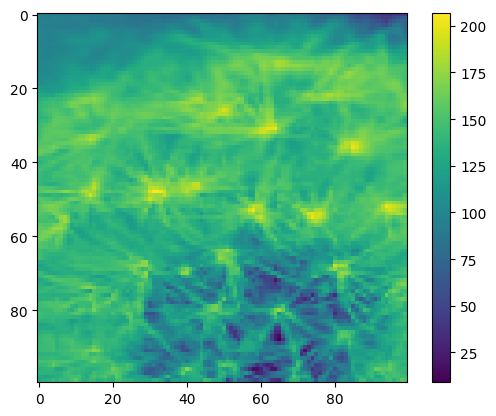

In [3]:
#(1)
#读取图像的源数据集。
de_dataset = ds.ImageFolderDataset(dataset_dir=cfg.data_path, 
                                   class_indexing={'daisy':0,
                                                   'dandelion':1,
                                                   'roses':2,
                                                   'sunflowers':3,
                                                   'tulips':4})

#(2)
#解码前将输入图像裁剪成任意大小和宽高比。
transform_img =  CV.RandomCropDecodeResize([cfg.image_width,cfg.image_height], scale=(0.08, 1.0), ratio=(0.75, 1.333)) #改变尺寸
#转换输入图像形状为（C, H, W）。
hwc2chw_op = CV.HWC2CHW()
#转换为给定MindSpore数据类型的Tensor操作。
type_cast_op = C.TypeCast(mstype.float32)
#将上述三个操作应用到此数据集。
de_dataset = de_dataset.map(input_columns="image", num_parallel_workers=8, operations=transform_img)
de_dataset = de_dataset.map(input_columns="image", num_parallel_workers=8, operations=hwc2chw_op)
de_dataset = de_dataset.map(input_columns="image", num_parallel_workers=8, operations=type_cast_op)
#打乱数据
de_dataset = de_dataset.shuffle(buffer_size=cfg.data_size)


#（3）
#划分训练集测试集
(de_train,de_test)=de_dataset.split([0.8,0.2])
print("训练集（张）："+str(de_train.count))
print("验证集（张）:"+str(de_test.count))

#（4）
#设置每个批处理的行数
de_train=de_train.batch(batch_size=cfg.batch_size, drop_remainder=True)
#de_train=de_train.repeat(cfg.epoch_size)
#重复此数据集计数次数。
de_test=de_test.batch(batch_size=cfg.batch_size, drop_remainder=True)
#de_test=de_test.repeat(cfg.epoch_size)
print('训练数据集数量：',de_train.get_dataset_size()*cfg.batch_size)#get_dataset_size()获取批处理的大小。
print('测试数据集数量：',de_test.get_dataset_size()*cfg.batch_size)

data_next=de_dataset.create_dict_iterator(output_numpy=True).__next__()
print('通道数/图像长/宽：', data_next['image'].shape)
print('一张图像的标签样式：', data_next['label']) # 一共5类，用0-4的数字表达类别。
plt.figure()
plt.imshow(data_next['image'][0,...])
plt.colorbar()
plt.grid(False)
plt.show()

### 定义CNN图像识别网络

In [4]:
# 定义CNN图像识别网络
class Identification_Net(nn.Cell):
    def __init__(self, num_class=5,channel=3,dropout_ratio=0.5,trun_sigma=0.01):  #需补充数值
        super(Identification_Net, self).__init__()
        self.num_class = num_class
        self.channel = channel
        self.dropout_ratio = dropout_ratio
        #设置卷积层、激活函数、最大池化层等
        self.conv1 = nn.Conv2d(self.channel, 32, kernel_size=5, stride=1, padding=0, has_bias=True, 
                               pad_mode="same", weight_init=TruncatedNormal(sigma=trun_sigma),
                               bias_init='zeros')
        self.relu = nn.ReLU()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2, pad_mode="valid")
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=0, has_bias=True, 
                               pad_mode="same", weight_init=TruncatedNormal(sigma=trun_sigma),
                               bias_init='zeros')
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=0, has_bias=True, 
                               pad_mode="same", weight_init=TruncatedNormal(sigma=trun_sigma),
                               bias_init='zeros')
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=0, has_bias=True, 
                               pad_mode="same", weight_init=TruncatedNormal(sigma=trun_sigma), 
                               bias_init='zeros')
        self.flatten = nn.Flatten()
        self.fc1 = nn.Dense(6*6*128, 1024,weight_init =TruncatedNormal(sigma=trun_sigma),bias_init = 0.1)
        self.dropout = nn.Dropout(self.dropout_ratio)
        self.fc2 = nn.Dense(1024, 512, weight_init=TruncatedNormal(sigma=trun_sigma), bias_init=0.1)
        self.fc3 = nn.Dense(512, self.num_class, weight_init=TruncatedNormal(sigma=trun_sigma), bias_init=0.1)

    #构建模型
    def construct(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv3(x)
        x = self.max_pool2d(x)
        x = self.conv4(x)
        x = self.max_pool2d(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x


### 模型训练、测试、预测

In [7]:
net=Identification_Net(num_class=cfg.num_class, channel=cfg.channel, dropout_ratio=cfg.dropout_ratio)

#计算softmax交叉熵。
net_loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction="mean")
#opt
fc_weight_params = list(filter(lambda x: 'fc' in x.name and 'weight' in x.name, net.trainable_params()))
other_params=list(filter(lambda x: 'fc' not in x.name or 'weight' not in x.name, net.trainable_params()))
group_params = [{'params': fc_weight_params, 'weight_decay': cfg.weight_decay},
                {'params': other_params},
                {'order_params': net.trainable_params()}]
#设置Adam优化器
net_opt = nn.Adam(group_params, learning_rate=cfg.lr, weight_decay=0.0)

model = Model(net, loss_fn=net_loss, optimizer=net_opt, metrics={"acc"})

loss_cb = LossMonitor(per_print_times=de_train.get_dataset_size()*10)
config_ck = CheckpointConfig(save_checkpoint_steps=cfg.save_checkpoint_steps, 
                             keep_checkpoint_max=cfg.keep_checkpoint_max)
ckpoint_cb = ModelCheckpoint(prefix=cfg.output_prefix, directory=cfg.output_directory, config=config_ck)

In [ ]:
print("============== Starting Training ==============")
model.train(cfg.epoch_size, de_train, callbacks=[loss_cb, ckpoint_cb], dataset_sink_mode=True)

# 使用测试集评估模型，打印总体准确率
metric = model.eval(de_test)
print(metric)

============== Starting Training ==============
epoch: 10 step: 91, loss is 1.2819503545761108
epoch: 20 step: 91, loss is 1.4434115886688232
epoch: 30 step: 91, loss is 1.262628436088562
epoch: 40 step: 91, loss is 1.006289005279541
epoch: 50 step: 91, loss is 1.0287652015686035
epoch: 60 step: 91, loss is 0.9059716463088989
epoch: 70 step: 91, loss is 1.1129941940307617
epoch: 80 step: 91, loss is 1.2483561038970947
epoch: 90 step: 91, loss is 0.9416579604148865
epoch: 100 step: 91, loss is 1.07289719581604
epoch: 110 step: 91, loss is 1.0389117002487183
epoch: 120 step: 91, loss is 0.9155880808830261
epoch: 130 step: 91, loss is 0.8149707913398743
epoch: 140 step: 91, loss is 1.3128622770309448
epoch: 150 step: 91, loss is 1.0043033361434937
epoch: 160 step: 91, loss is 0.7351493835449219
epoch: 170 step: 91, loss is 0.5505446195602417
epoch: 180 step: 91, loss is 1.2248870134353638
epoch: 190 step: 91, loss is 0.7681244015693665
epoch: 200 step: 91, loss is 0.8460633754730225
epoch

In [18]:
#加载训练好的模型
CKPT = './model/checkpoint_classification_4-600_91.ckpt'
net = Identification_Net(num_class=cfg.num_class, channel=cfg.channel, dropout_ratio=cfg.dropout_ratio)
load_checkpoint(CKPT, net=net)
model = Model(net)

# 进行预测
class_names = {0:'daisy',1:'dandelion',2:'roses',3:'sunflowers',4:'tulips'}
test_ = de_test.create_dict_iterator().__next__()
test = Tensor(test_['image'], mindspore.float32)
predictions = model.predict(test)
predictions = predictions.asnumpy()
true_label = test_['label'].asnumpy()

#显示Num个样本的预测结果，并和真实结果进行对比（Num无限制）
Num = 10
for i in range(Num):
    p_np = predictions[i, :]
    p_list = p_np.tolist()
    pre_label = class_names[p_list.index(max(p_list))]
    true = class_names[true_label[i]]
    print('第' + str(i) + '个sample预测结果：', pre_label, '     \t真实结果：', true)

第0个sample预测结果： tulips      	真实结果： tulips
第1个sample预测结果： roses      	真实结果： roses
第2个sample预测结果： dandelion      	真实结果： dandelion
第3个sample预测结果： dandelion      	真实结果： dandelion
第4个sample预测结果： daisy      	真实结果： daisy
第5个sample预测结果： sunflowers      	真实结果： sunflowers
第6个sample预测结果： tulips      	真实结果： roses
第7个sample预测结果： sunflowers      	真实结果： sunflowers
第8个sample预测结果： sunflowers      	真实结果： tulips
第9个sample预测结果： tulips      	真实结果： tulips
